# Rossmann Drug Store Sales

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# importing train data to learn
# train = pd.read_csv("./train.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'Date')
train = pd.read_csv("./train.csv", 
                    parse_dates = True, low_memory = False)

# additional store data
store = pd.read_csv("./store.csv", 
                    low_memory = False)
# time series as indexes
train.index

RangeIndex(start=0, stop=1017209, step=1)

# Exploratory Data Analysis

First, we go through the dataset to understand what we have.
  - In "Open" column, we have 0 and 1. 0 stand for the store is close, and 1 stand for open.
  - In "Promo" column, we also have 0 and 1. 1 still stand for having promotion, 0 is not.
  - .......
    

In [3]:
print("In Total:", train.shape)
train.head(5)

In Total: (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train[train['Customers']==0].head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


In [5]:
train['Date'] = pd.to_datetime(train['Date'], format = "%Y-%m-%d")

In [6]:
train['SalePerCustomer'] = train['Sales']/ train['Customers']
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118


In [7]:
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [8]:
train.groupby('Store')['SalePerCustomer'].describe().head(5)

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
1,781.0,8.393038,0.689619,6.513228,7.903475,8.362376,8.891304,10.536503
2,784.0,8.408443,0.994872,3.869416,7.716940,8.313092,9.014858,11.890588
3,779.0,9.117599,1.091865,6.840056,8.195019,9.123440,9.954838,13.150880
4,784.0,7.249827,0.504537,6.003643,6.857851,7.215175,7.570805,9.342457
5,779.0,8.611229,1.003729,6.444840,7.834218,8.584677,9.245045,12.078512


At the first sight, on average the customer spend 9.49$ per day

# Dealing with missing values

- We use ECDF (Empirical Cumulative Distribution Function) to know how many percent of the value less than "a" in dataset.

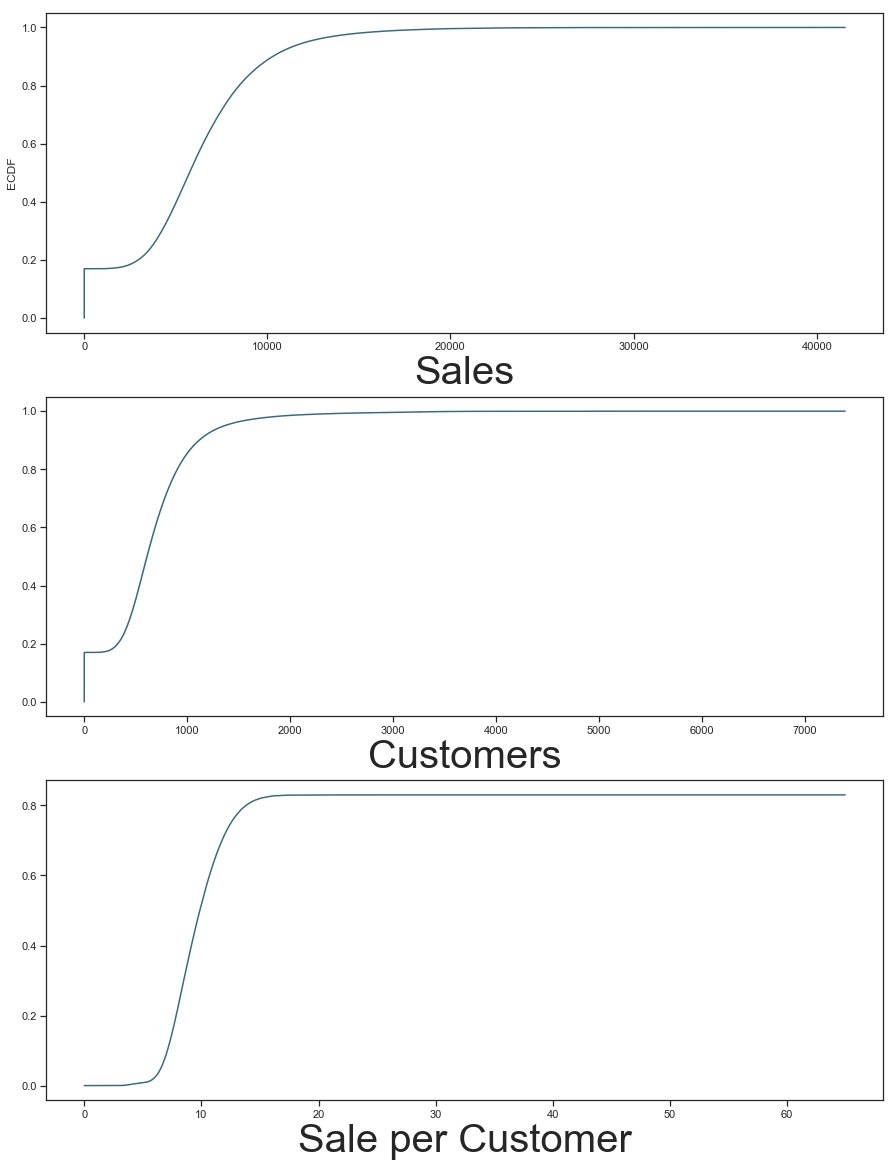

In [9]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (15, 20))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales', fontsize = 40); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers', fontsize=40);

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer', fontsize = 40);

- The Sales Chart, we have nearly 20% of sale is 0. 
- And that case, it is not vlaue for predicting. So, we need to remove or replace it. 
- when sales is 0, we have 2 case. first is the store was closed or open but they can not sold anything.

In [10]:
# sales equal 0
Total_Sales_0 = train[train['Sales']==0]
Sales_0_Open = train[(train['Sales']==0) & (train['Open']!=0)]
Sales_0_Close = train[(train['Sales']==0) & (train['Open']==0)]
print('Total Sales 0:', Total_Sales_0.shape[0])
print("\n")
print("Case Sale was 0 and store was Open", Sales_0_Open.shape[0])
print("\n")
print("Case Sale was 0 and store was Close ", Sales_0_Close.shape[0])

Total Sales 0: 172871


Case Sale was 0 and store was Open 54


Case Sale was 0 and store was Close  172817


We just have 54 case in total 844340, so we can remove it but it not effect to dataset

In [11]:
train = train[(train['Open']!=0) & (train['Sales']!=0)]
print("After remove, we have dataset in total is:", train.shape)

After remove, we have dataset in total is: (844338, 10)


# Dealing with store dataset

In [12]:
store = pd.read_csv("./store.csv")

In [13]:
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
store.shape

(1115, 10)

In [15]:
store['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [16]:
store['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

Check missing value (NaN) of store dataset

In [17]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [18]:
# fill NA in column Competition
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median(), inplace = True)
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace = True)

In [19]:
# with missing value in column about promotion, it's simple have no promotion.
# So we just have replace missing = 0
store.fillna(0, inplace = True)

In [20]:
train_all = pd.merge(train, store, how = 'inner' , on = 'Store')
train_all.shape
train_all.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [21]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 19 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null datetime64[ns]
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
SalePerCustomer              844338 non-null float64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64


So now we have final dataset, let go futher to another part

In [22]:
train_all.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [23]:
train_all.groupby('StoreType')['SalePerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,8.846296,1.690913,3.635389,7.611945,8.631363,9.899438,29.877551
b,15560.0,5.133427,1.253988,2.749075,4.039561,4.987022,6.108760,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


In [24]:
train_all = train_all.set_index('Date')
train_all.sort_index(inplace=True)

In [25]:
train_all_m = train_all.groupby([pd.Grouper(freq='M')]).sum()

In [26]:
train_all_m.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,SalePerCustomer,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Date,,,,,,,,,,,,,,
2013-01-31,16118876,101277,180132207,20380423,28865,11062,3886,265631.275368,155669280.0,215906.0,57992216.0,14785,350043.0,29743848.0
2013-02-28,14886979,93735,171534275,19244468,26682,11099,2656,247653.473121,144356090.0,199506.0,53606658.0,13681,323076.0,27522932.0
2013-03-31,15561002,100857,201180369,21969462,27891,15558,4576,265551.020539,151388005.0,208584.0,56035607.0,14289,337240.0,28746099.0
2013-04-30,15557765,96266,183431432,20882360,27878,13307,4294,255665.350200,151805315.0,208461.0,56009476.0,14242,336308.0,28651461.0
2013-05-31,14617034,96167,185411063,20723886,26199,12677,3418,245054.639189,143707635.0,195977.0,52636554.0,13279,312741.0,26714198.0


In [27]:
np.set_printoptions(precision=4)
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [10, 7]

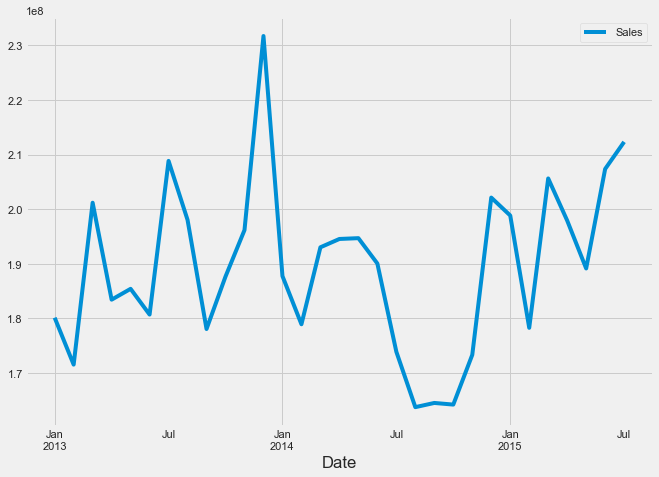

In [28]:
train_all_m.plot(y='Sales')

In [29]:
train_all_m.columns[2:]

Index(['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'SalePerCustomer', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear'],
      dtype='object')

In [30]:
len(train_all_m.columns[2:])

12

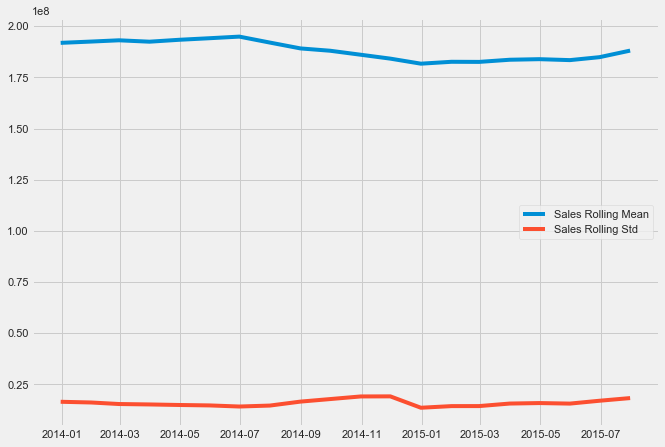

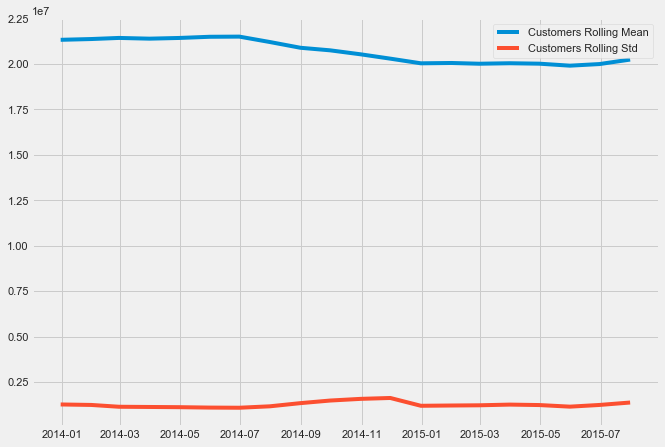

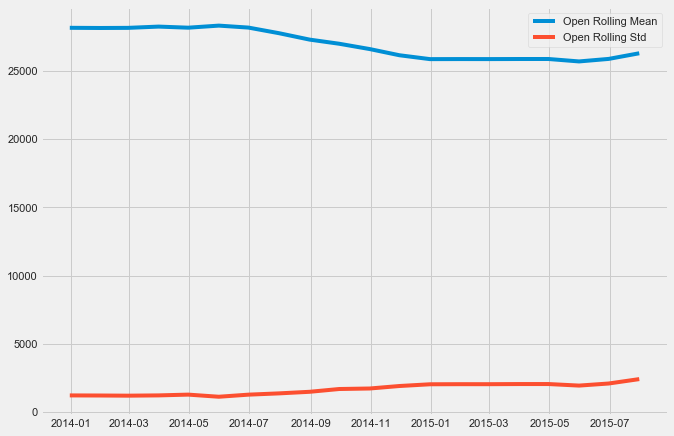

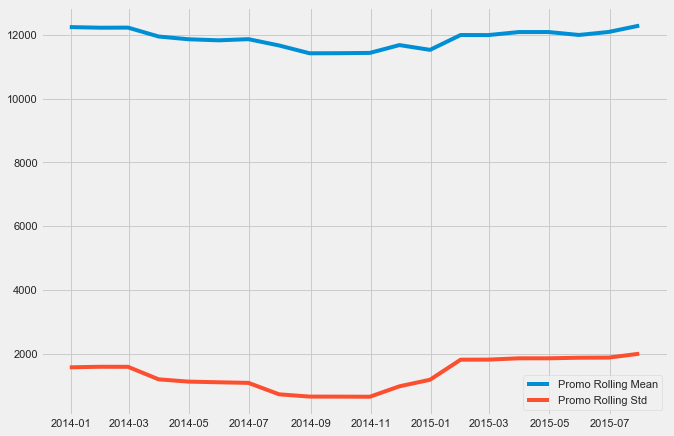

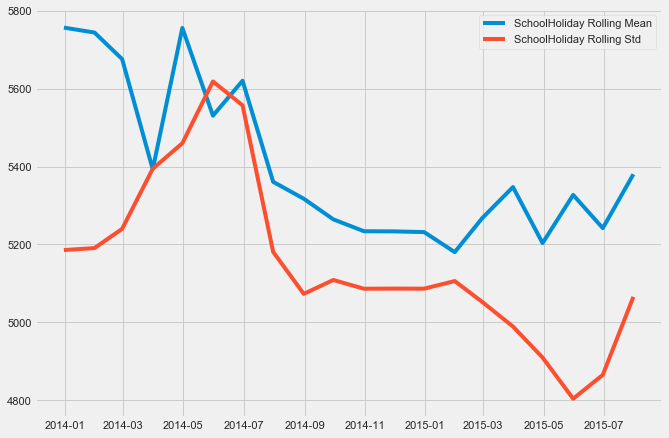

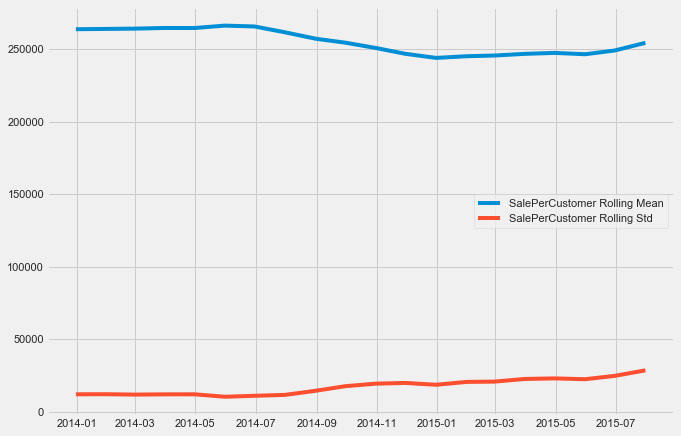

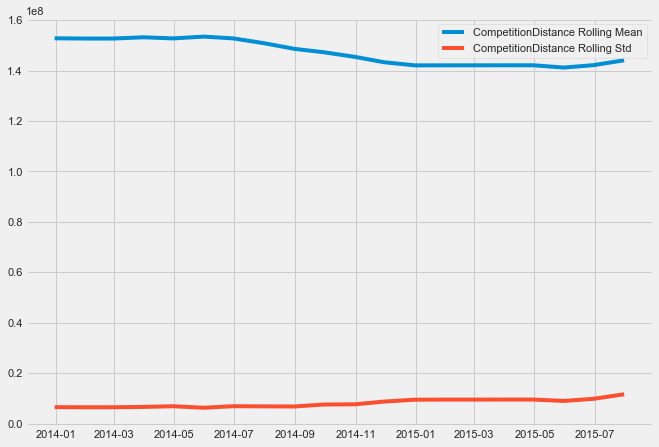

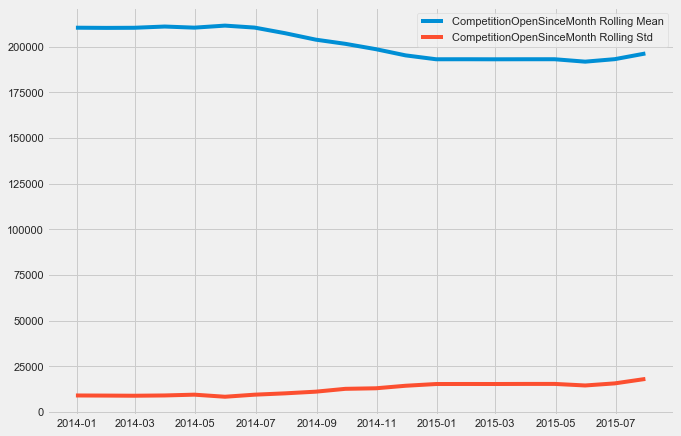

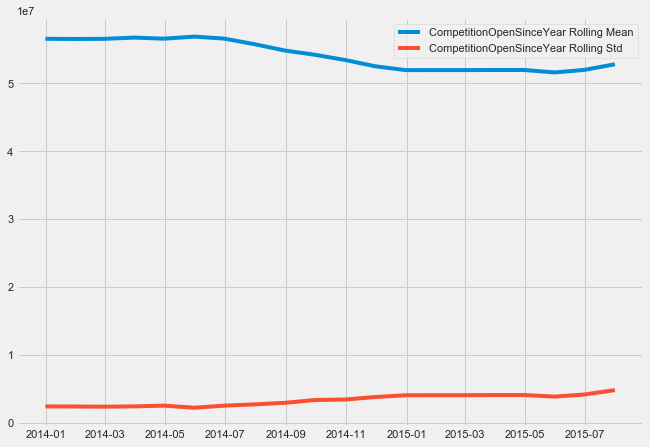

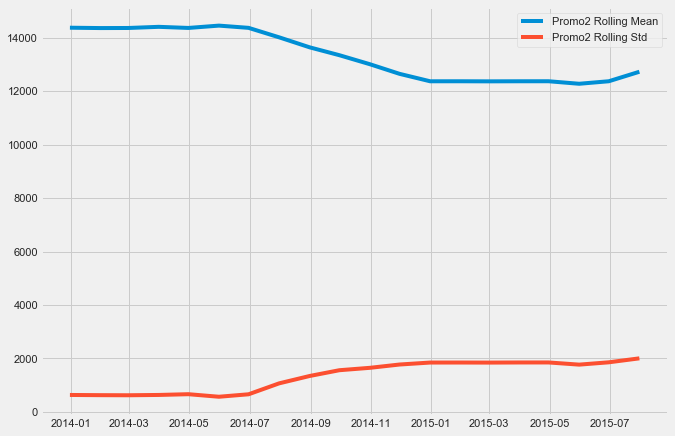

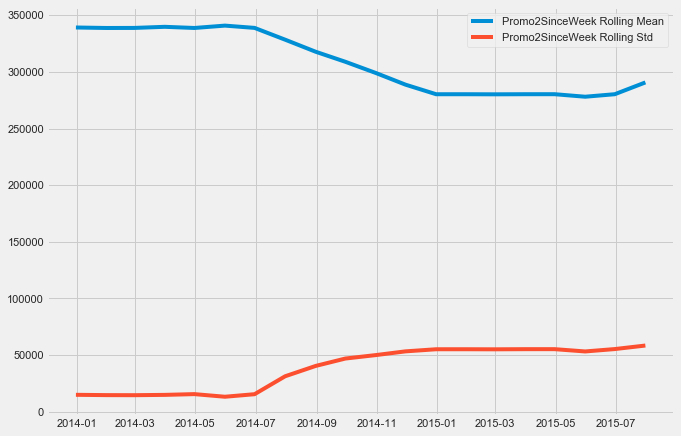

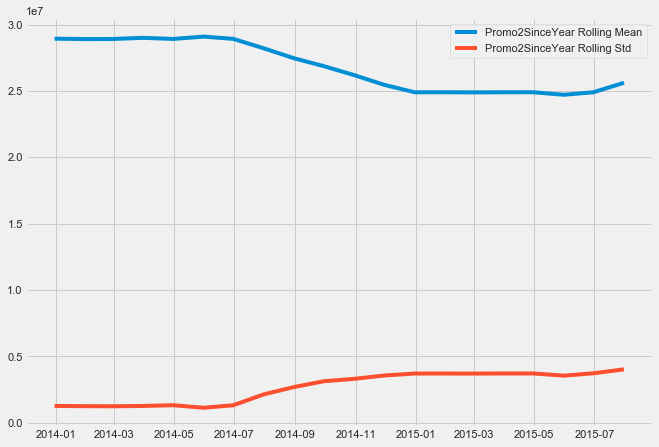

In [31]:
for i in range(12):
    plt.plot(train_all_m[f'{train_all_m.columns[2:][i]}'].rolling(window=12).mean(), label = f"{train_all_m.columns[2:][i]} Rolling Mean")
    plt.plot(train_all_m[f'{train_all_m.columns[2:][i]}'].rolling(window=12).std(), label = f"{train_all_m.columns[2:][i]} Rolling Std")
    plt.legend()
    plt.show()

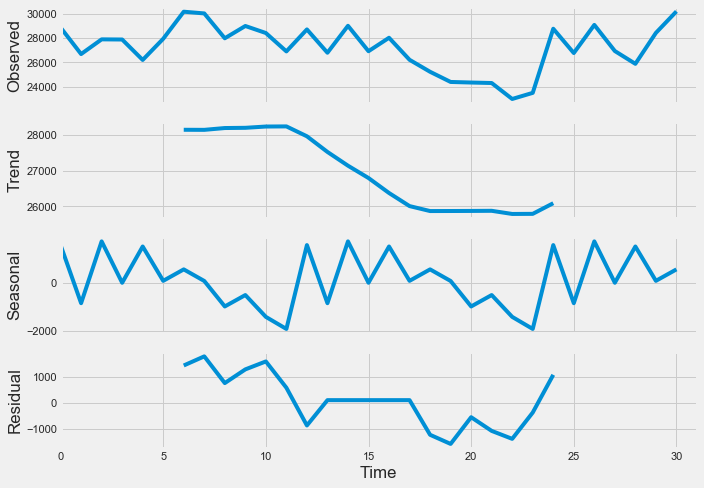

In [32]:
res = seasonal_decompose(train_all_m.Open.values,freq=12,model="additive")
fig = res.plot()

In [33]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [34]:
test_stationarity(train_all_m.Sales.values)

Results of Dickey-Fuller Test:
Test Statistic                 -3.544365
p-value                         0.006918
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


In [35]:
test_stationarity(train_all_m.Sales.diff(1).dropna().values)

Results of Dickey-Fuller Test:
Test Statistic                -5.956607e+00
p-value                        2.086051e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.800000e+01
Critical Value (1%)           -3.688926e+00
Critical Value (5%)           -2.971989e+00
Critical Value (10%)          -2.625296e+00
dtype: float64


In [36]:
ts = train_all_m.Sales.diff(6).dropna()

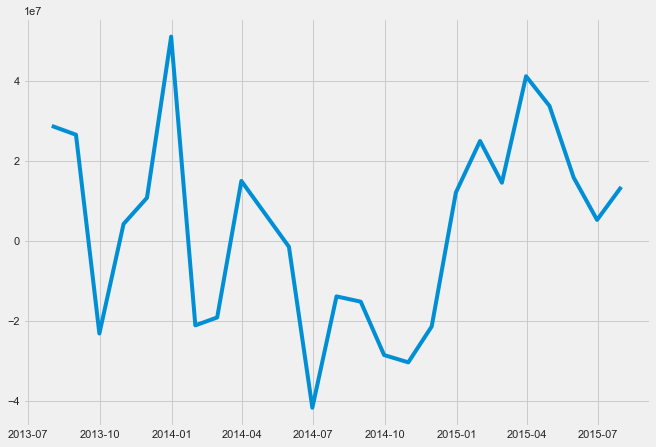

In [37]:
plt.plot(ts)

In [38]:
from scipy.stats import probplot

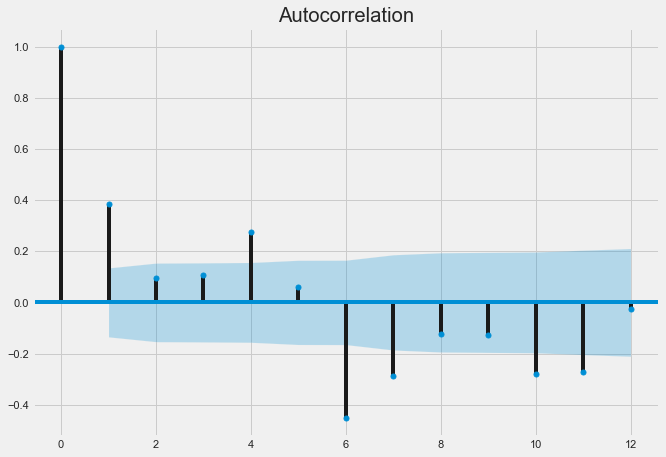

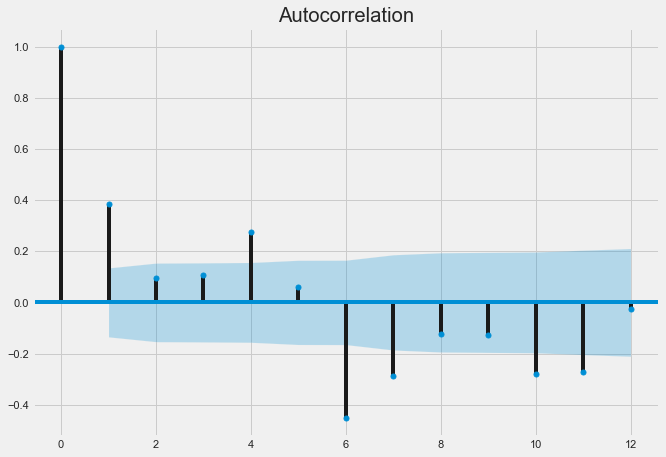

In [39]:
plot_acf(ts, lags=12, alpha=0.5)

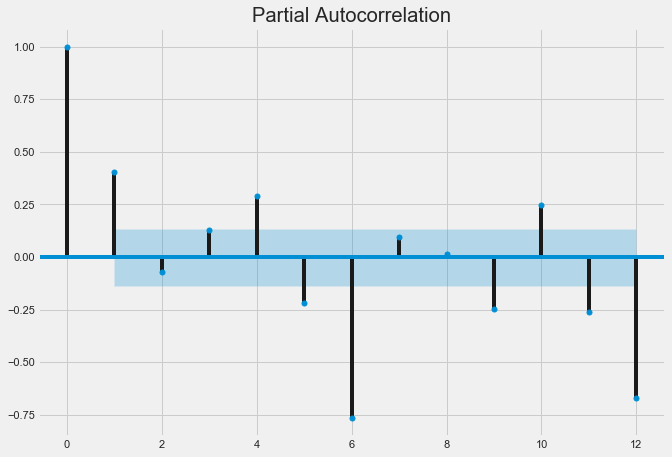

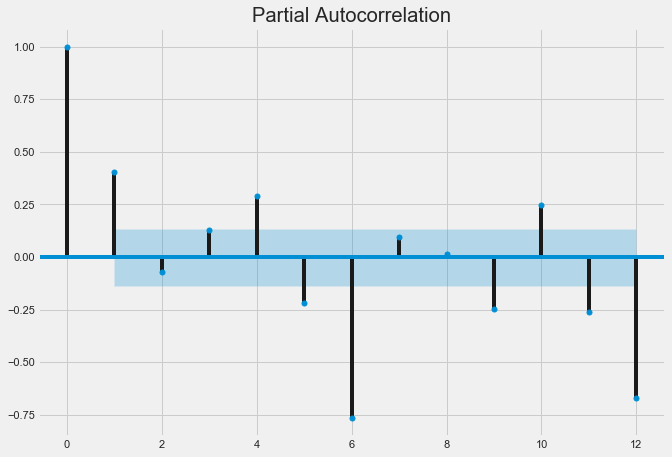

In [40]:
plot_pacf(ts, lags=12, alpha=0.5)

In [41]:
from statsmodels.tsa.arima_model import ARMA
best_aic = np.inf
best_order = None
best_model = None

rng = range(5)
for i in rng:
    for j in rng:
        if i == j == 0:
            continue
        try:
            model = ARMA(ts, order=(i, j)).fit(method='mle', trend='nc')
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (i, j)
                best_model = model
        except: continue
print('AIC: {:6.5} | order: {}'.format(best_aic, best_order))

E:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
E:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC: 918.59 | order: (2, 4)


In [42]:
predict = best_model.predict(start=0, end=25)

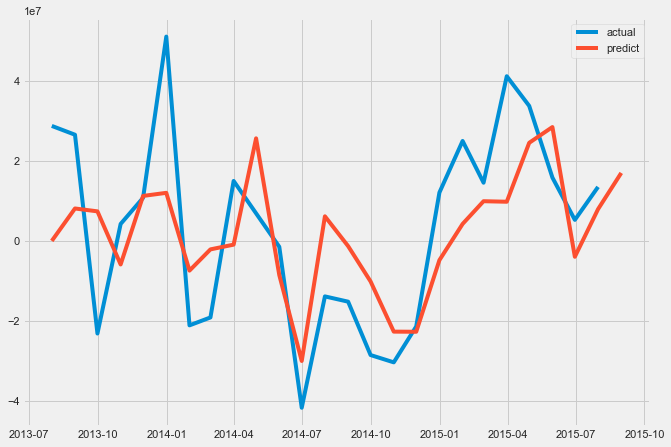

In [43]:
plt.plot(ts, label='actual');
plt.plot(predict, label='predict');
plt.legend()